Importing tools and dataset

In [12]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
data = pd.read_csv("C:/Users/Admin/OneDrive/Desktop/Last Sem Degree/PSM2/Coding/data.csv")
data.head(10)

# Display the first few rows of the dataframe to inspect the data
print("Original Data:")
print(data.head())

# Display data types to identify any non-numeric columns
print("\nData Types:")
print(data.dtypes)

# Check for any non-numeric values in the data
print("\nNon-numeric Values:")
print(data[~data.map(np.isreal)])


Original Data:
   Unnamed: 0   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  X171  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   -15   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   150   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57    64   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   -81   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 180 columns]

Data Types:
Unnamed: 0    object
X1             int64
X2             int64
X3             int64
X4             int64
               ...  
X175           int64
X176           int64
X177       

In [14]:
# Display the data types of each column
print("Data Types of Each Column:")
print(data.dtypes)

# Count the number of columns by data type
print("\nNumber of Columns by Data Type:")
print(data.dtypes.value_counts())


Data Types of Each Column:
Unnamed: 0    object
X1             int64
X2             int64
X3             int64
X4             int64
               ...  
X175           int64
X176           int64
X177           int64
X178           int64
y              int64
Length: 180, dtype: object

Number of Columns by Data Type:
int64     179
object      1
Name: count, dtype: int64


In [15]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Unnamed: 0    0
X1            0
X2            0
X3            0
X4            0
             ..
X175          0
X176          0
X177          0
X178          0
y             0
Length: 180, dtype: int64


In [16]:
# check for null values
print("Null values found:")
print(data.isnull().sum()) # sum null values in columns

# Check for negative values
print("\nNegative values found:")
numerical_columns = data.select_dtypes(include=['int64','float64']). columns # select numerical columns
negative_values = (data[numerical_columns]< 0 ).sum() # Count negative value per column
print(negative_values)

Null values found:
Unnamed: 0    0
X1            0
X2            0
X3            0
X4            0
             ..
X175          0
X176          0
X177          0
X178          0
y             0
Length: 180, dtype: int64

Negative values found:
X1      6348
X2      6328
X3      6265
X4      6272
X5      6337
        ... 
X175    6412
X176    6423
X177    6416
X178    6387
y          0
Length: 179, dtype: int64


In [17]:
# check for non numerical columns
non_numeric_columns = data.select_dtypes(exclude=['int64','float64']).columns           # filter column that are not numerical (e.g. strings, dates, etc)

# Print Result
if len(non_numeric_columns) > 0:
    print("\nNon-numeric columns found:")
    print(non_numeric_columns)
    print(f"\nNumber of non-numeric columns: {len(non_numeric_columns)}")                  # Show how many non-numeric columns
else:
    print("All column in the dataset are numerical.")


Non-numeric columns found:
Index(['Unnamed: 0'], dtype='object')

Number of non-numeric columns: 1


In [18]:
# Drop unnamed columns (if any)
data = data.drop(columns=["Unnamed"], errors='ignore')

# Rename 'y' to 'label'
if 'y' in data.columns:
    data.rename(columns={'y': 'label'}, inplace=True)

# Convert label to binary: 1 = seizure, 0 = non-seizure
data['label'] = data['label'].apply(lambda x: 1 if x == 1 else 0)

# Clean features: convert all to numeric and fill NaNs
X_raw = data.drop("label", axis=1).apply(pd.to_numeric, errors='coerce')
X_raw = X_raw.fillna(0)

# Combine cleaned features and label
data_cleaned = X_raw.copy()
data_cleaned["label"] = data["label"]

# Save cleaned dataset
data_cleaned.to_csv("cleaned_epileptic_seizure_dataset.csv", index=False)
print("✅ Cleaned dataset saved as 'cleaned_epileptic_seizure_dataset.csv'")

✅ Cleaned dataset saved as 'cleaned_epileptic_seizure_dataset.csv'


In [19]:
# STEP 3: Feature Extraction Functions

def extract_time_features(signal):
    return [
        np.mean(signal),
        np.std(signal),
        skew(signal),
        kurtosis(signal),
        np.sqrt(np.mean(signal ** 2)),  # RMS
        np.sum(signal ** 2)             # Energy
    ]

def extract_frequency_features(signal):
    fft_vals = np.abs(fft(signal))
    freqs, psd = welch(signal)
    spectral_centroid = np.sum(freqs * psd) / (np.sum(psd) + 1e-10)
    spectral_entropy = -np.sum((psd / np.sum(psd) + 1e-12) * np.log2(psd / np.sum(psd) + 1e-12))
    return [
        np.max(fft_vals),               # Max FFT value
        spectral_centroid,
        spectral_entropy
    ]

In [20]:
# STEP 4: Apply Feature Extraction to Each Signal Row

# Reload cleaned dataset (just in case)
df_cleaned = pd.read_csv("cleaned_epileptic_seizure_dataset.csv")

# Separate X and y
X_raw = df_cleaned.drop("label", axis=1)
y = df_cleaned["label"]

# Extract features for every row
features = []
for i in range(len(X_raw)):
    signal = X_raw.iloc[i].values.astype(float)
    time_feats = extract_time_features(signal)
    freq_feats = extract_frequency_features(signal)
    features.append(time_feats + freq_feats)

# Create features DataFrame
X_features = pd.DataFrame(features, columns=[
    "mean", "std_dev", "skewness", "kurtosis", "rms", "energy",
    "fft_max", "spectral_centroid", "spectral_entropy"
])

X_features.head()

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 179, using nperseg = 179
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


,mean,std_dev,skewness,kurtosis,rms,energy,fft_max,spectral_centroid,spectral_entropy
0,-16.815642,95.451556,-0.203774,0.084375,96.921439,1681484.0,6808.648799,0.061065,3.339430
1,27.955307,470.520665,-1.514281,1.364085,471.350396,39768644.0,30957.590627,0.033433,3.425248
2,-43.798883,44.184906,0.480598,-0.260840,62.214532,692846.0,7840.000000,0.056552,4.286367
3,-68.525140,16.689179,0.641166,1.208768,70.528175,890386.0,12266.000000,0.056238,4.385423
4,-6.614525,38.587954,-0.466784,-0.234184,39.150761,274368.0,2600.029662,0.060774,4.397681


In [21]:
# STEP 5: Split and Scale Data

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# STEP 6: Train SVM Classifier

svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [23]:
# STEP 7: Evaluate Model

y_pred = svm.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[1817   23]
 [  27  433]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1840
           1       0.95      0.94      0.95       460

    accuracy                           0.98      2300
   macro avg       0.97      0.96      0.97      2300
weighted avg       0.98      0.98      0.98      2300

Accuracy Score: 0.9782608695652174


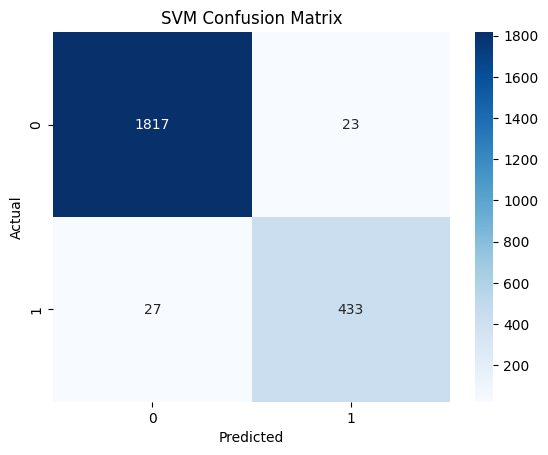

In [24]:
# STEP 8: Visualize Confusion Matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM Confusion Matrix")
plt.show()

In [25]:
# STEP 8A: Create Evaluation Metrics Table for SVM


# Data from classification report
results = {
    "Class": ["Non-Seizure (0)", "Seizure (1)"],
    "Precision": [0.99, 0.95],
    "Recall": [0.99, 0.94],
    "F1-score": [0.99, 0.95],
    "Support": [1840, 460]
}

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display the table
print("📊 Evaluation Metrics Table:")
display(results_df)


📊 Evaluation Metrics Table:


,Class,Precision,Recall,F1-score,Support
0,Non-Seizure (0),0.99,0.99,0.99,1840
1,Seizure (1),0.95,0.94,0.95,460


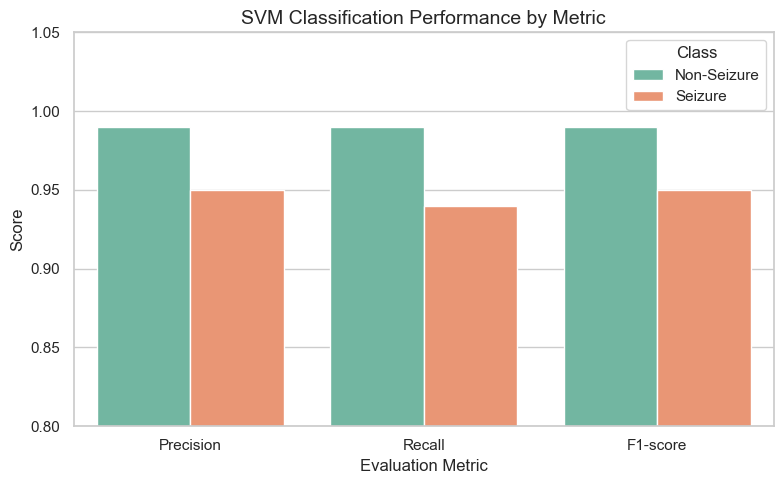

In [26]:
# Simulate classification report data
results_df = pd.DataFrame({
    "Class": ["Non-Seizure", "Seizure"],
    "Precision": [0.99, 0.95],
    "Recall": [0.99, 0.94],
    "F1-score": [0.99, 0.95]
})

# Set plot style
sns.set(style="whitegrid")

# Plot grouped bar chart
results_df_melted = results_df.melt(id_vars="Class", var_name="Metric", value_name="Score")

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df_melted, x="Metric", y="Score", hue="Class", palette="Set2")
plt.ylim(0.8, 1.05)
plt.title("SVM Classification Performance by Metric", fontsize=14)
plt.ylabel("Score")
plt.xlabel("Evaluation Metric")
plt.legend(title="Class")
plt.tight_layout()